In [1]:
import sim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.integrate
import scipy.misc
from tqdm import tqdm

$$
\begin{align*}

\text{For a sphere with } x(t) &= [\sqrt{D^2 - z^2}]\cos(t) + x_1\\
y(t) &= [\sqrt{D^2 - z^2}]\sin(t) + y_1\\
z(t) &= z\\

\\

\text{The radius, } r(t) &= \sqrt{x(t)^2 + y(t)^2 + z^2}\\

\\

\text{If we have a density $\rho$, such that } \rho &= \rho(r),\\

\\

\text{Then the mass around the circle } &= \int_0^{2\pi} \rho(r(t))\sqrt{{\begin{bmatrix} \frac{dx}{dt} \end{bmatrix}}^2 + {\begin{bmatrix} \frac{dy}{dt} \end{bmatrix}}^2} \; dt\\

\\

{\begin{bmatrix} \frac{dx}{dt} \end{bmatrix}}^2 + {\begin{bmatrix} \frac{dy}{dt} \end{bmatrix}}^2 &= (D^2 - z^2)\sin^2(t) + (D^2 - z^2)\cos^2(t)\\
&= (D^2 - z^2)\\

\\

\text{The mass around a sphere of radius D, } M(D) &= \int_{-D}^{D} \frac{D}{\sqrt{D^2 - z^2}} \int_0^{2\pi} \rho(r(t))\sqrt{{\begin{bmatrix} \frac{dx}{dt} \end{bmatrix}}^2 + {\begin{bmatrix} \frac{dy}{dt} \end{bmatrix}}^2} \; dt \: dz \\

&= \int_{-D}^{D} \frac{D}{\sqrt{D^2 - z^2}} \int_0^{2\pi} \rho(r(t))\sqrt{D^2 - z^2} \; dt \: dz \\
&= \int_{-D}^{D} \frac{D\sqrt{D^2 - z^2}}{\sqrt{D^2 - z^2}} \int_0^{2\pi} \rho(r(t)) \; dt \: dz \\
&= D \int_{-D}^{D} \int_0^{2\pi} \rho(r(t)) \; dt \: dz \\

\\

\phi(D) &= -G \int_{-D}^{D} \int_0^{2\pi} \rho(r(t)) \; dt \: dz \\

\end{align*}
$$

In [2]:
def r_t(D,z,t,x_1,y_1):
    mul = np.sqrt((D**2) - (z**2))
    x = x_1 + mul*np.cos(t)
    y = y_1 + mul*np.sin(t)
    r = np.sqrt((x**2) + (y**2) + (z**2))
    return r

class Uniform(object):
    @staticmethod
    def rho(r,p0,radius=1):
        if r > radius:
            return 0
        else:
            return p0
    
    @staticmethod
    def mass(D,x_1,y_1,p0,radius):
        def func(t,z):
            return Uniform.rho(r_t(D,z,t,x_1,y_1),p0,radius)
        integral = scipy.integrate.dblquad(func,-D,D,0,2*np.pi,epsrel=1e-1)
        return D * integral[0],integral[1]
    
    @staticmethod
    def phi(D,x_1,y_1=0,G=1,radius=1,M=1):
        if D == 0:
            return 0
        p0 = M/((4/3) * np.pi * (radius**2))
        mass = Uniform.mass(D,x_1,y_1,p0,radius)
        return ((-G * mass[0]) / D)
    
    @staticmethod
    def phis(xs,ri):
        out = np.zeros_like(xs)
        step = xs[1] - xs[0]
        for idx,x in enumerate(xs):
            out[idx] = Uniform.phi(x,ri,0,1,1,1) * step
        return out

class NFW(object):
    @staticmethod
    def rho(r,p0,Rs):
        if r > 3:
            return 0
        return p0 / ((r/Rs) * (1 + (r/Rs))**2)
    
    @staticmethod
    def mass(D,x_1,y_1,p0,Rs):
        def func(t,z):
            return NFW.rho(r_t(D,z,t,x_1,y_1),p0,Rs)
        integral = scipy.integrate.dblquad(func,-D,D,0,2*np.pi,epsrel=1e-1)
        return D * integral[0],integral[1]
    
    @staticmethod
    def phi(D,x_1,y_1=0,G=1,c=5,Mvir=1):
        if D == 0:
            return 0
        Rs = 1/c
        p0 = Mvir / (4 * np.pi * (Rs**3) * (np.log(1+c) - (c/(1+c))))
        mass = NFW.mass(D,x_1,y_1,p0,Rs)
        return ((-G * mass[0]) / D)
    
    @staticmethod
    def phis(xs,ri,c=5,Mvir=1):
        out = np.zeros_like(xs)
        step = xs[1] - xs[0]
        for idx,x in enumerate(xs):
            out[idx] = NFW.phi(x,ri,c=c,Mvir=Mvir) * step
        return out

In [3]:
all_xs = []
all_ys = []
for ri in tqdm(np.linspace(0,1,11)):
    xs = np.linspace(0,1+ri,50)
    ys = Uniform.phis(xs,ri)
    all_xs.append(xs)
    all_ys.append(ys)

100%|██████████| 11/11 [01:39<00:00,  9.08s/it]


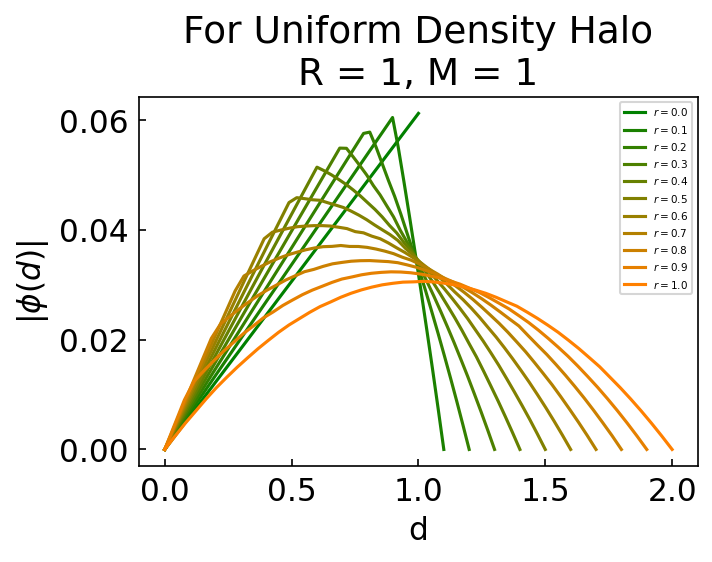

In [4]:
sim.pretty_plots.plot_pretty()
for xs,ys,label in zip(all_xs,all_ys,np.linspace(0,1,11)):
    plt.plot(xs,np.abs(ys),label=str(r"$r=") + str(round(label,2)) + r"$",color=(label,0.5,0))
plt.legend()
plt.title("For Uniform Density Halo\nR = 1, M = 1")
plt.xlabel("d")
plt.ylabel(r"$|\phi(d)|$")
plt.tight_layout()
plt.savefig("uniform.jpg")
plt.show()

In [5]:
all_xs = []
all_ys = []
c = 5
for ri in tqdm(np.linspace(0,1,11)):
    xs = np.linspace(0,3+ri,100)
    ys = NFW.phis(xs,ri,c=c)
    all_xs.append(xs)
    all_ys.append(ys)

100%|██████████| 11/11 [01:38<00:00,  8.95s/it]


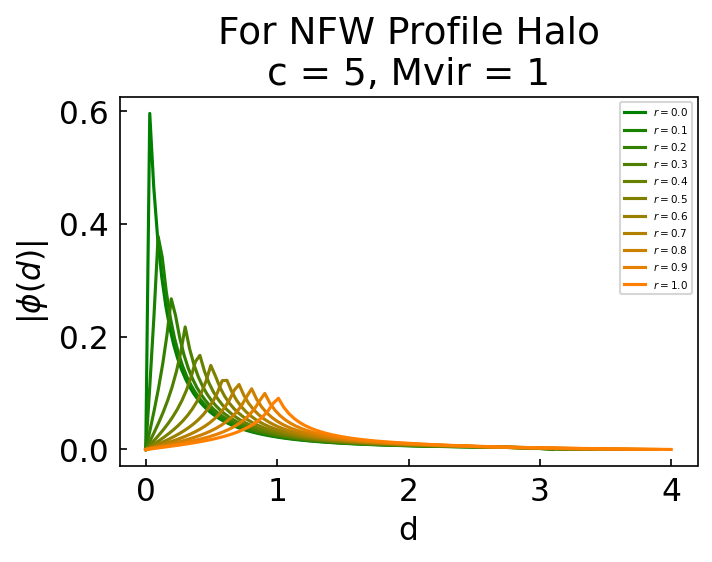

In [6]:
sim.pretty_plots.plot_pretty()
for xs,ys,label in zip(all_xs,all_ys,np.linspace(0,1,11)):
    plt.plot(xs,np.abs(ys),label=str(r"$r=") + str(round(label,2)) + r"$",color=(label,0.5,0))
plt.legend()
plt.title("For NFW Profile Halo\nc = " + str(c) + ", Mvir = 1")
plt.xlabel("d")
plt.ylabel(r"$|\phi(d)|$")
plt.tight_layout()
plt.savefig("NFWc5.jpg")
plt.show()

In [7]:
all_xs = []
all_ys = []
c = 15
for ri in tqdm(np.linspace(0,1,11)):
    xs = np.linspace(0,3+ri,100)
    ys = NFW.phis(xs,ri,c=c)
    all_xs.append(xs)
    all_ys.append(ys)

100%|██████████| 11/11 [01:38<00:00,  8.94s/it]


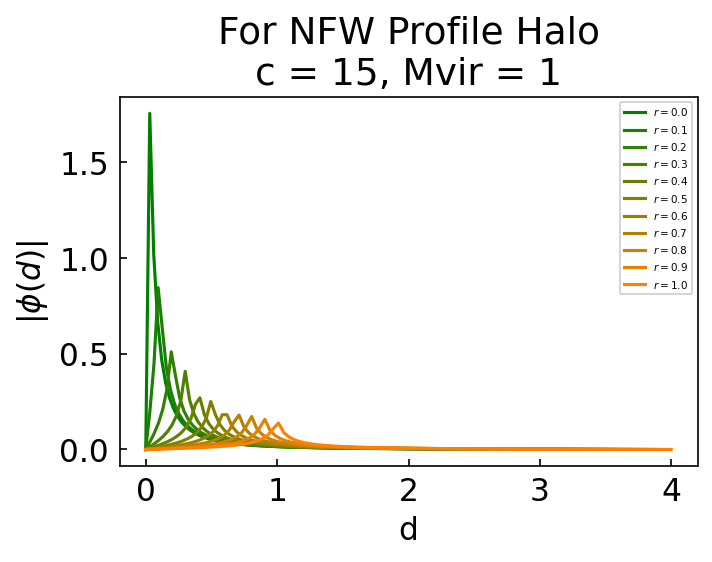

In [8]:
sim.pretty_plots.plot_pretty()
for xs,ys,label in zip(all_xs,all_ys,np.linspace(0,1,11)):
    plt.plot(xs,np.abs(ys),label=str(r"$r=") + str(round(label,2)) + r"$",color=(label,0.5,0))
plt.legend()
plt.title("For NFW Profile Halo\nc = " + str(c) + ", Mvir = 1")
plt.xlabel("d")
plt.ylabel(r"$|\phi(d)|$")
plt.tight_layout()
plt.savefig("NFWc15.jpg")
plt.show()

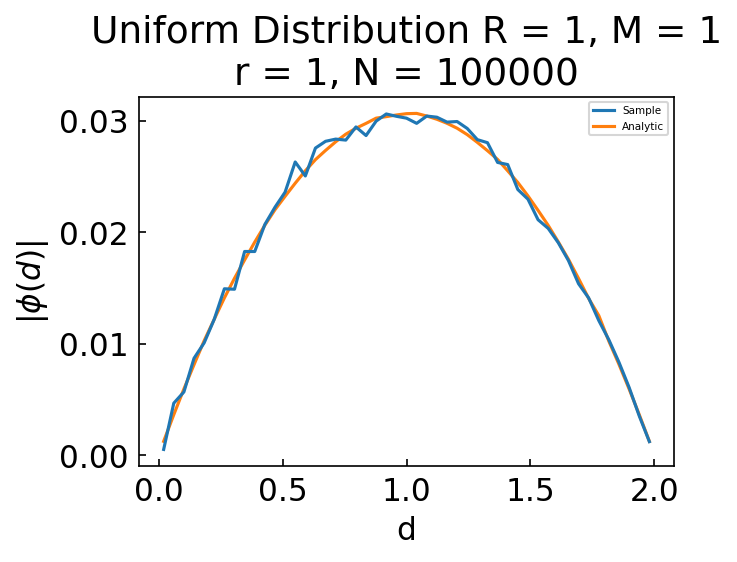

In [9]:
sim.pretty_plots.plot_pretty()

n = 100000
r = 1
ri = 1
G = 1
M = 1
p0 = M/((4/3) * np.pi * (r**2))

sampled = sim.halos.Sample.Uniform(n,r=r,M=M)
particles = sampled.loc[:,["x","y","z"]].to_numpy()

dists = np.linalg.norm(particles - np.array([ri,0,0]),axis=1)
M = sampled["mass"][0]
phis = -G * M / dists

nbins = 50

bins = np.linspace(0,r + ri,nbins)
start = bins[:-1]
end = bins[1:]
step = bins[1]-bins[0]
xs = (end-start)/2 + start
ys = []
ahh = 0
for idx in range(len(start)):
    temp_dists = dists[dists > start[idx]]
    temp_phis = phis[dists > start[idx]]
    temp_phis = temp_phis[temp_dists <= end[idx]]
    ahh += len(temp_phis)
    ys.append(np.sum(temp_phis))

ana_phis = Uniform.phis(xs,ri)

plt.plot(xs,np.abs(ys),zorder=1,label="Sample")
plt.plot(xs,np.abs(np.array(ana_phis)),zorder=0,label="Analytic")

plt.ylabel(r"$|\phi(d)|$")
plt.xlabel(r"d")

plt.legend()

plt.title("Uniform Distribution R = 1, M = 1\nr = " + str(ri) + ", N = " + str(n))

plt.tight_layout()
plt.show()

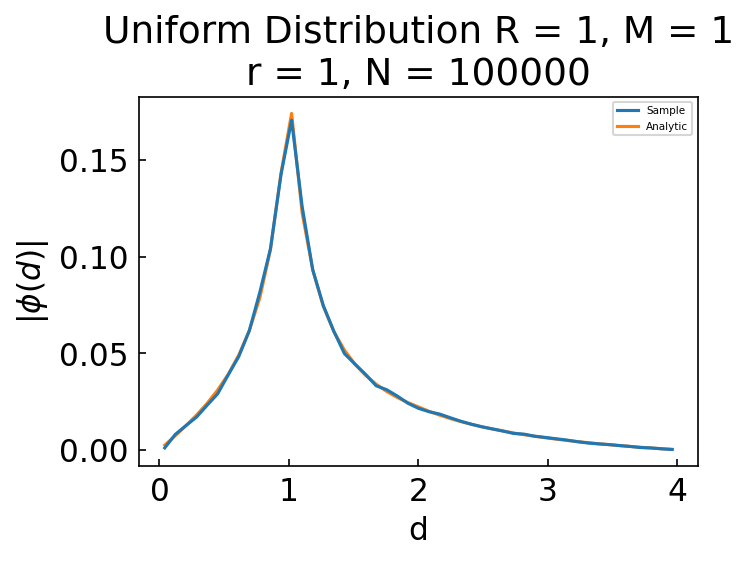

In [10]:
sim.pretty_plots.plot_pretty()

n = 100000
ri = 1
r = 3
G = 1
c = 5

sampled = sim.halos.Sample.NFW(n,c=c,a=r,Mvir=1)
particles = sampled.loc[:,["x","y","z"]].to_numpy()

dists = np.linalg.norm(particles - np.array([ri,0,0]),axis=1)
M = sampled["mass"][0]
phis = -G * M / dists

nbins = 50

bins = np.linspace(0,r + ri,nbins)
start = bins[:-1]
end = bins[1:]
step = bins[1]-bins[0]
xs = (end-start)/2 + start
ys = []
ahh = 0
for idx in range(len(start)):
    temp_dists = dists[dists > start[idx]]
    temp_phis = phis[dists > start[idx]]
    temp_phis = temp_phis[temp_dists <= end[idx]]
    ahh += len(temp_phis)
    ys.append(np.sum(temp_phis))

ana_phis = NFW.phis(xs,ri,c=c)

plt.plot(xs,np.abs(ys),zorder=1,label="Sample")
plt.plot(xs,np.abs(np.array(ana_phis)),zorder=0,label="Analytic")

plt.ylabel(r"$|\phi(d)|$")
plt.xlabel(r"d")

plt.legend()

plt.title("Uniform Distribution R = 1, M = 1\nr = " + str(ri) + ", N = " + str(n))

plt.tight_layout()
plt.show()